# APS360 Group 42

> ## GAN Pokemon




In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import random
from skimage.util import random_noise



#### First we scrape the images from the pokemondb website and save them.

In [ ]:
if not os.path.isdir('ImageData'):
  os.mkdir('ImageData')
if not os.path.isdir('ImageData/NormalImages'):
  os.mkdir('ImageData/NormalImages')
if not os.path.isdir('ImageData/ShinyImages'):
  os.mkdir('ImageData/ShinyImages')

In [ ]:
import requests
from bs4 import BeautifulSoup
print("Running image scraper...")
#URL= "https://bulbapedia.bulbagarden.net/wiki/List_of_Pok%C3%A9mon_by_National_Pok%C3%A9dex_number"
URL= "https://pokemondb.net/pokedex/shiny"
getURL = requests.get(URL, headers={"User-Agent":"Mozilla/5.0"})
print("Status code: ", getURL.status_code)

soup = BeautifulSoup(getURL.text, 'html.parser')
images = soup.find_all('img')

imageSourcesNorm = []
imageSourcesShiny = []

for image in images:
        text = image.get('src')
        #print("IMAGE: ")
        #print(image)
        #print("#########")
        #print("TEXT: ")
        #print(text)
        #print("-------------------------------")
        if text != None :
            if 'normal' in text:
                imageSourcesNorm.append(text)
            if 'shiny' in text:
                imageSourcesShiny.append(text)

print('Downloading Normal Images...')
for image in imageSourcesNorm:
    #webs = requests.get("https:" + image) #For scraping from bulbapedia / relative URLs
    webs = requests.get(image)
    open('/content/ImageData/NormalImages/' + image.split('/')[-1], 'wb').write(webs.content)

print('Downloading Shiny Images...')
for image in imageSourcesShiny:
    webs = requests.get(image)
    open('/content/ImageData/ShinyImages/' + image.split('/')[-1], 'wb').write(webs.content)

print("Done.")

Running image scraper...
Status code:  200
Done.


In [ ]:
import requests
from bs4 import BeautifulSoup
print("Running image scraper...")
URL= "https://bulbapedia.bulbagarden.net/wiki/List_of_Pok%C3%A9mon_by_National_Pok%C3%A9dex_number"
getURL = requests.get(URL, headers={"User-Agent":"Mozilla/5.0"})
print("Status code: ", getURL.status_code)

soup = BeautifulSoup(getURL.text, 'html.parser')
images = soup.find_all('img')

image_sources = []

for image in images:
  text = image.get('src')
  if 'bulbagarden' in text:
    image_sources.append("https:" + text)

print('Downloading Bulbapedia Images')
for image in image_sources:
    #print(image)
    webs = requests.get(image)
    open('/content/ImageData/NormalImages/' + image.split('/')[-1], 'wb').write(webs.content)

print('Done.')

Running image scraper...
Status code:  200
Done.


Now we use another page from the pokemondb website to obtain the newest generation pokemon sprites

In [ ]:
if not os.path.isdir('ImageData/Gen9Images'):
  os.mkdir('ImageData/Gen9Images')

In [ ]:
URL= "https://pokemondb.net/pokedex/national#gen-9"
getURL = requests.get(URL, headers={"User-Agent":"Mozilla/5.0"})
print("Status code: ", getURL.status_code)

soup = BeautifulSoup(getURL.text, 'html.parser')
sources = soup.find_all('img')

new_gen_images = []

for source in sources:
  text = source.get('src')
  if text is not None:
    if 'scarlet-violet' in text:
      new_gen_images.append(text)

print("Downloading Gen 9 Images...")
for source in new_gen_images:
  print(source)
  webs = requests.get(source)
  open('/content/ImageData/Gen9Images/' + source.split('/')[-1], 'wb').write(webs.content)

print("Done Gen 9 Images")

Status code:  200
https://img.pokemondb.net/sprites/scarlet-violet/normal/sprigatito.png
https://img.pokemondb.net/sprites/scarlet-violet/normal/floragato.png
https://img.pokemondb.net/sprites/scarlet-violet/normal/meowscarada.png
https://img.pokemondb.net/sprites/scarlet-violet/normal/fuecoco.png
https://img.pokemondb.net/sprites/scarlet-violet/normal/crocalor.png
https://img.pokemondb.net/sprites/scarlet-violet/normal/skeledirge.png
https://img.pokemondb.net/sprites/scarlet-violet/normal/quaxly.png
https://img.pokemondb.net/sprites/scarlet-violet/normal/quaxwell.png
https://img.pokemondb.net/sprites/scarlet-violet/normal/quaquaval.png
https://img.pokemondb.net/sprites/scarlet-violet/normal/lechonk.png
https://img.pokemondb.net/sprites/scarlet-violet/normal/oinkologne.png
https://img.pokemondb.net/sprites/scarlet-violet/normal/tarountula.png
https://img.pokemondb.net/sprites/scarlet-violet/normal/spidops.png
https://img.pokemondb.net/sprites/scarlet-violet/normal/nymble.png
https://im

KeyboardInterrupt: ignored

These gen 9 images are missing the white background, so we add them to keep them in line with the other images.

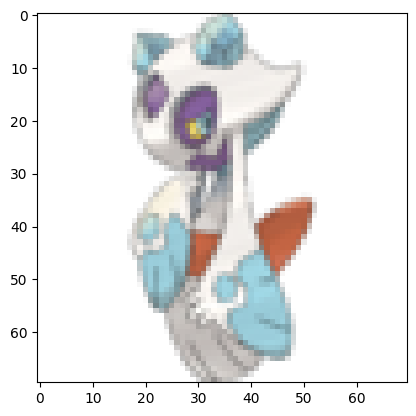

In [ ]:
#based off https://stackoverflow.com/questions/3803888/how-to-load-png-images-with-4-channels
from PIL import Image
#path = '/content/ImageData/Gen9Images/'
path = '/content/ImageData/NormalImages/'
show = True
for image_src in os.listdir(path):
  #print(image_src)
  img = cv2.imread(path + image_src, cv2.IMREAD_UNCHANGED)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGBA)
  alpha_channel = img[:, :, 3]
  rgb_channels = img[:, :,:3]

  white = np.ones_like(rgb_channels, dtype = np.uint8) * 255
  alpha_factor = alpha_channel[:, :, np.newaxis].astype(np.float32) / 255
  alpha_factor = np.concatenate((alpha_factor,alpha_factor,alpha_factor), axis=2)

  base = rgb_channels.astype(np.float32) * alpha_factor
  white = white.astype(np.float32) * (1 - alpha_factor)
  final_image = (base + white).astype(np.uint8)
  save_image = Image.fromarray(final_image)
  save_image.save(path + image_src)

  if show:
    plt.imshow(img)
    show = False


Now that we have all pokemon from generations 1-9, we can artificially generate "shinies" to augment the dataset by permuting the rgb axes of the image

['70px-0478Froslass.png', '70px-Munkidori.png', '70px-0218Slugma.png', '70px-0849Toxtricity-Low_Key.png', '70px-0695Heliolisk.png', '70px-0682Spritzee.png', '70px-0628Braviary-Hisui.png', '70px-0192Sunflora.png', '70px-0005Charmeleon.png', '70px-0390Chimchar.png', '70px-0048Venonat.png', '70px-0091Cloyster.png', '70px-0430Honchkrow.png', '70px-0853Grapploct.png', '70px-0164Noctowl.png', '70px-0564Tirtouga.png', '70px-0110Weezing.png', '70px-0336Seviper.png', '70px-0296Makuhita.png', '70px-0020Raticate.png', '70px-0128Tauros-Paldea_Blaze.png', '70px-0137Porygon.png', '70px-0231Phanpy.png', '70px-0297Hariyama.png', '70px-0308Medicham.png', '70px-0386Deoxys-Defense.png', '70px-0723Dartrix.png', '70px-0639Terrakion.png', '70px-0743Ribombee.png', '70px-0462Magnezone.png', '70px-0557Dwebble.png', '70px-0107Hitmonchan.png', '70px-0716Xerneas.png', '70px-0056Mankey.png', '70px-0337Lunatone.png', '70px-0327Spinda.png', '70px-0610Axew.png', '70px-HOME0649R.png', '70px-0885Dreepy.png', '70px-HOME

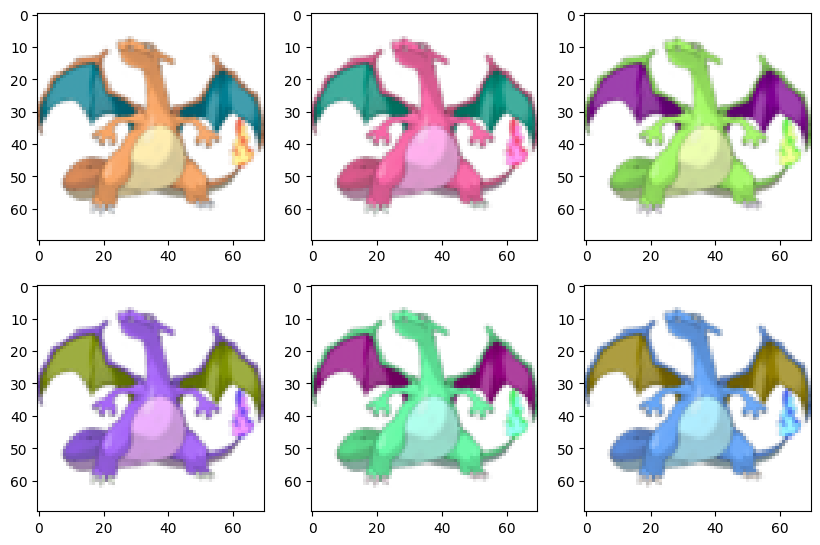

In [ ]:
import itertools

def generate_color_swaps(channels, img):
  new_img = np.ones_like(img, dtype = np.uint8) * 255
  for x in range(img.shape[0]):
    for y in range(img.shape[1]):
      old_color = img[x, y]
      new_color = [old_color[channels[0]], old_color[channels[1]], old_color[channels[2]]]
      new_img[x, y] = new_color

  return new_img

def generate_all_color_swaps(img):
  channel_permutations = list(itertools.permutations([0, 1, 2]))
  #channel_permutations.remove((0, 1, 2))
  new_imgs = []
  for perm in channel_permutations:
    new_imgs.append(generate_color_swaps(perm, img))

  return new_imgs


#path = '/content/ImageData/Gen9Images/'
path = '/content/ImageData/NormalImages/'
names = os.listdir(path)
print(names)
index = np.random.randint(len(names))
img = cv2.imread(path + names[index], cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

new_imgs = generate_all_color_swaps(img)

fig = plt.figure(figsize=(10, 10))

for i in range(len(new_imgs)):
  fig.add_subplot(3, 3, i + 1)
  plt.imshow(new_imgs[i])

Now we generate these augmented shinies for every pokemon  and complete the dataset

In [ ]:
import shutil
shutil.rmtree('/content/ImageData/FakeShinyImages/')

In [ ]:
normal_path = '/content/ImageData/NormalImages/'
shiny_path = '/content/ImageData/ShinyImages/'
gen9_path = '/content/ImageData/Gen9Images/'
#augment_path = '/content/ImageData/FakeShinyImages/'
augment_path = "/content/drive/MyDrive/Colab Notebooks/BulbaData/real/"

if not os.path.isdir(augment_path):
  os.mkdir(augment_path)

normal_images = os.listdir(normal_path)
shiny_images = os.listdir(shiny_path)
gen9_images = os.listdir(gen9_path)

for img_src in normal_images:
  img = cv2.imread(normal_path + img_src, cv2.IMREAD_UNCHANGED)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  new_imgs = generate_all_color_swaps(img)
  img_num = 1
  for new_img in new_imgs:
    save_img = Image.fromarray(new_img)
    if img_num == 1:
      save_img.save(augment_path + img_src[:-4] + "_normal_" + str(img_num) + img_src[-4:])
    else:
      save_img.save(augment_path + img_src[:-4] + "_augmented_" + str(img_num) + img_src[-4:])
    img_num += 1
"""
for img_src in shiny_images:
  img = cv2.imread(shiny_path + img_src, cv2.IMREAD_UNCHANGED)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  save_img = Image.fromarray(img)
  save_img.save(augment_path + img_src[:-4] + "_shiny_" + str(img_num) + img_src[-4:])

for img_src in gen9_images:
  #if os.path.isfile(augment_path + img_src[:-4] + "_gen9" + img_src):
    #continue
  img = cv2.imread(gen9_path + img_src, cv2.IMREAD_UNCHANGED)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  new_imgs = generate_all_color_swaps(img)
  img_num = 1
  for new_img in new_imgs:
    save_img = Image.fromarray(new_img)
    if img_num == 1:
      save_img.save(augment_path + img_src[:-4] + "_gen9_" + str(img_num) + img_src[-4:])
    else:
      save_img.save(augment_path + img_src[:-4] + "_augmented_" + str(img_num) + img_src[-4:])
    img_num += 1
"""

'\nfor img_src in shiny_images:\n  img = cv2.imread(shiny_path + img_src, cv2.IMREAD_UNCHANGED)\n  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)\n  save_img = Image.fromarray(img)\n  save_img.save(augment_path + img_src[:-4] + "_shiny_" + str(img_num) + img_src[-4:])\n\nfor img_src in gen9_images:\n  #if os.path.isfile(augment_path + img_src[:-4] + "_gen9" + img_src):\n    #continue\n  img = cv2.imread(gen9_path + img_src, cv2.IMREAD_UNCHANGED)\n  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)\n  new_imgs = generate_all_color_swaps(img)\n  img_num = 1\n  for new_img in new_imgs:\n    save_img = Image.fromarray(new_img)\n    if img_num == 1:\n      save_img.save(augment_path + img_src[:-4] + "_gen9_" + str(img_num) + img_src[-4:])\n    else:\n      save_img.save(augment_path + img_src[:-4] + "_augmented_" + str(img_num) + img_src[-4:])\n    img_num += 1\n'

###Next we convert the saved images into a numpy data set.


In [ ]:
if not os.path.isdir('/content/ImageData/NpyData'):
  os.mkdir('/content/ImageData/NpyData')

In [ ]:
#making the data into a npy file
#from: https://medium.com/analytics-vidhya/create-your-own-real-image-dataset-with-python-deep-learning-b2576b63da1e

training_data = []
path = '/content/ImageData/NormalImages'
for img in os.listdir(path):
  pic = cv2.imread(os.path.join(path,img))
  pic = cv2.resize(pic,(256,256))
  pic = cv2.cvtColor(pic,cv2.COLOR_BGR2RGB)
  # rand angle -90 to 90
  angle = random.randint(-90, 90)
  rows, cols = pic[:2]
  M = cv2.getRotationMatrix2D((256/2, 256/2), angle, 1)
  pic_rotated = cv2.warpAffine(pic, M, (pic.shape[1], pic.shape[0]),
                               borderMode = cv2.BORDER_CONSTANT, borderValue=(255,255,255))
  pic_noisy = cv2.GaussianBlur(pic, (5,5), 0)

  #Transformation without rotation
  h = pic.shape[0]
  w = pic.shape[1]
  half_height, half_width = h/4, w/8
  transition_matrix = np.float32([[1, 0, half_width], [0, 1, half_height]])

  pic_translated = cv2.warpAffine(pic, transition_matrix, (w, h),
                                  borderMode = cv2.BORDER_CONSTANT, borderValue=(255,255,255))

  pic_averaged = cv2.blur(pic, (5,5))

  training_data.extend([pic, pic_rotated, pic_noisy, pic_averaged, pic_translated])

path = '/content/ImageData/ShinyImages/'
for img in os.listdir(path):
  pic = cv2.imread(os.path.join(path,img))
  pic = cv2.resize(pic,(256,256))
  pic = cv2.cvtColor(pic,cv2.COLOR_BGR2RGB)
  training_data.append([pic])

np.save(os.path.join('/content/ImageData/NpyData','features'),np.array(training_data))
saved = np.load(os.path.join('/content/ImageData/NpyData','features.npy'), allow_pickle=True)

#plt.imshow(np.array(training_data[0]).reshape(256,256,3))

<ipython-input-25-a4454431c8f5>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(os.path.join('/content/ImageData/NpyData','features'),np.array(training_data))


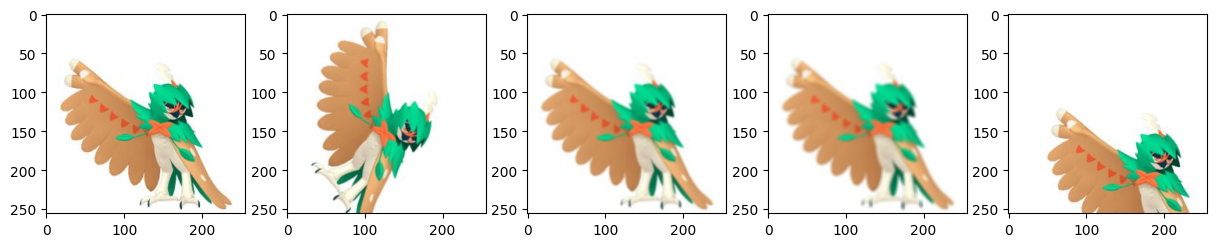

In [ ]:
fig = plt.figure(figsize=(15, 15))
for i in range(5):
  fig.add_subplot(5, 5, i + 1)
  plt.imshow(saved[i])
#plt.savefig('additionalaugmentaion.jpg')

####we can change the above code to make the images 70x70 so that we can expand our data set using the Bulbapedia sprites as well (which are already 70x70)

True

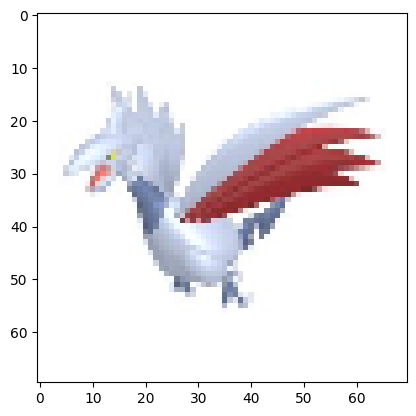

In [ ]:
exampleResize = cv2.imread('/content/ImageData/NormalImages/skarmory.jpg')
exampleResize = cv2.cvtColor(exampleResize,cv2.COLOR_BGR2RGB)
exampleResize = cv2.resize(exampleResize, (70, 70))
plt.imshow(exampleResize)

#resave the image using:
cv2.imwrite('resized_skarmory.jpg', cv2.cvtColor(exampleResize, cv2.COLOR_RGB2BGR))

In [ ]:
#could make a custom data set class
class PokemonDataSet(torch.utils.data.Dataset):
  def __init__(self, input_file_path, transform=None):
    super().__init__()
    self.path = input_file_path
    self.transform = transform

    with np.load(self.path) as fh:
      self.data = fh
      self.labels = 0

  def __getitem__(self, index):
    data = self.data[index]
    label = 0
    if self.transform:
      img = self.transform(img)
    return img, label
  def __len__(self):
    return len(self.data)

In [ ]:
# Spliting dataset into training, validation adn testing

import shutil
from google.colab.patches import cv2_imshow

parent_path = "/content/drive/MyDrive/Colab Notebooks/PokemonData/"
training_path = parent_path + 'training'
validation_path = parent_path + 'validation'
testing_path = parent_path + 'testing'
full_path = parent_path + 'real/'

if not os.path.isdir(training_path):
  os.mkdir(training_path)
if not os.path.isdir(validation_path):
  os.mkdir(validation_path)
if not os.path.isdir(testing_path):
  os.mkdir(testing_path)

last_pokemon = os.listdir(full_path)[0]
last_pokemon_dash = last_pokemon.split('-')[0]
last_pokemon_underscore = last_pokemon.split('_')[0]

if len(last_pokemon_underscore) < len(last_pokemon_dash):
  last_pokemon = last_pokemon_underscore
else:
  last_pokemon = last_pokemon_dash

j = 0
for i, img in enumerate(os.listdir(full_path)):

  # finding the pokemon name (parse name into whichever comes first, '-' or '_')
  pokemon_name_dash = img.split('-')[0]
  pokemon_name_underscore = img.split('_')[0]

  if len(pokemon_name_underscore) < len(pokemon_name_dash):
    pokemon_name = pokemon_name_underscore
  else:
    pokemon_name = pokemon_name_dash

  # replace the last_pokemon with new pokemon name
  if pokemon_name != last_pokemon:
    j += 1
    last_pokemon = pokemon_name


  if j%8 == 0 :
    shutil.copy(full_path + img, validation_path)
  elif j%9 == 0:
    shutil.copy(full_path + img, testing_path)
  else:
    shutil.copy(full_path + img, training_path)

  print(img, pokemon_name, last_pokemon, i, j)




In [ ]:
#or if we split up the images into their train / vlidation / testing folders
#we can use a data loader like from lab 3
def data_loader ():
  transform = transforms.Compose([transforms.ToTensor()])
  testing_path = '/content/ImageData/Training'
  vali_path = '/content/ImageData/Validation'
  train_path = '/content/ImageData/Testing'

  train_set = torchvision.datasets.ImageFolder(train_path, transform=transform)
  validation_set = torchvision.datasets.ImageFolder(vali_path, transform=transform)
  test_set = torchvision.datasets.ImageFolder(testing_path, transform=transform)
  print('Done Loading.')
  return train_set, validation_set, test_set

In [ ]:
#ignore
!unzip /content/PokemonData-20230318T001712Z-001.zip -d /content/PokemonData/

unzip:  cannot find or open /content/PokemonData-20230318T001712Z-001.zip, /content/PokemonData-20230318T001712Z-001.zip.zip or /content/PokemonData-20230318T001712Z-001.zip.ZIP.


In [ ]:
#prepping folder to be a data set
transform_mirror = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((64,64)),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                transforms.CenterCrop((64, 64)),
                                transforms.RandomHorizontalFlip(p=1.0)
                                #transforms.GaussianBlur(3)
                                ])
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((64,64)),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                transforms.CenterCrop((64, 64))
                                #transforms.GaussianBlur(3)
                                ])

#data_path = '/content/drive/MyDrive/PokemonData'
# data_path = "/content/drive/MyDrive/Colab Notebooks/PokemonData/real"
data_path = "/content/drive/MyDrive/Colab Notebooks/BulbaData"
normal_set = torchvision.datasets.ImageFolder(data_path, transform=transform)
mirror_set = torchvision.datasets.ImageFolder(data_path, transform = transform_mirror)
data_set = torch.utils.data.ConcatDataset([normal_set, mirror_set])
print(data_set)

##Baseline

For the baseline we can follow what we previously outlined in the proposal.
Using a method to add noise such as this: https://theailearner.com/2019/05/07/add-different-noise-to-an-image/
and then averaging the values of some images.


In [ ]:
print(saved.shape) #we can use the previous numpy array in the baseline

(6432,)


In [ ]:
def randomList(size, low=0, high=1):
  randList = []
  for i in range(0, size):
    randList.append(np.random.randint(low, high))
  return randList

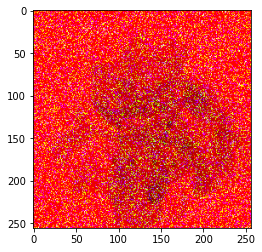

In [ ]:
avg_img = np.zeros(saved[0].shape, dtype=float)
avg_img.reshape(256,256,3)

randList = randomList(5 ,high=saved.shape[0]-1)
#index = np.random.randint(saved.shape[0]-1) #take the average of 5 random pokemon images
iterations = 5
for i in range(iterations):
  avg_img = cv2.add(avg_img, np.array(saved[randList[i]], dtype=float))
  #avg_img = np.array(saved[index+i], dtype=float).reshape(256,256,3) + avg_img

avg_img = cv2.divide(avg_img, iterations)
avg_img = np.array(np.round(avg_img),dtype=np.uint8).reshape(256, 256, 3)

# Taken from link provided above
gauss = np.random.normal(0, 1, avg_img.size)
gauss = gauss.reshape(avg_img.shape[0], avg_img.shape[1], avg_img.shape[2]).astype('uint8')
avg_img = cv2.add(avg_img,gauss)

plt.imshow(avg_img)
#cv2.imwrite('avg_img.jpg', cv2.cvtColor(avg_img, cv2.COLOR_RGB2BGR))

In [ ]:
cv2.imwrite('avg_img.jpg', cv2.cvtColor(avg_img, cv2.COLOR_RGB2BGR))

True

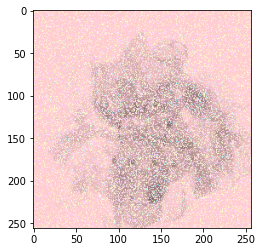

In [ ]:
#from https://stackoverflow.com/questions/50474302/how-do-i-adjust-brightness-contrast-and-vibrance-with-opencv-python

#now we increase the contrast and saturation of the image
value = 50
hsv = cv2.cvtColor(avg_img, cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(hsv)
#h += value # 4
s += value # 5
#v += value # 6
final_hsv = cv2.merge((h, s, v))
new_img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2RGB)

plt.imshow(new_img)

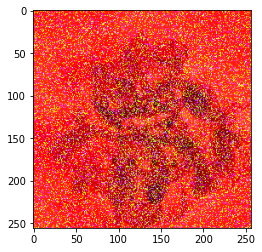

In [ ]:
clahe = cv2.createCLAHE(clipLimit=3., tileGridSize=(8,8))
new_img = avg_img
lab = cv2.cvtColor(new_img, cv2.COLOR_RGB2LAB)  # convert from BGR to LAB color space
l, a, b = cv2.split(lab)  # split on 3 different channels
l2 = clahe.apply(l)  # apply CLAHE to the L-channel

lab = cv2.merge((l2,a,b))  # merge channels
img2 = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)  # convert from LAB to BGR
plt.imshow(img2)
#cv2.imwrite('img2.jpg', cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))

###DCGAN

In [ ]:
#Based off DCGAN architectures from similar tasks as outlined in proposal:
# https://github.com/yashy3nugu/Anime-Face-GAN
# https://blog.jovian.com/pokegan-generating-fake-pokemon-with-a-generative-adversarial-network-f540db81548d

"""
class Discriminator(nn.Module):
  def __init__(self, batch_size):
    super(Discriminator, self).__init__()
    self.name = "Discriminator"
    self.model = nn.Sequential(
      # Input 3 x 64 x 64
      nn.Conv2d(3, 64, 3, stride = 2, padding = 1, bias = False),
      nn.LeakyReLU(0.2, inplace = True),
      # Output 64 x 32 x 32
      nn.Conv2d(64, 128, 3, stride = 2, padding = 1, bias = False),
      nn.BatchNorm2d(128),
      nn.LeakyReLU(0.2, inplace = True),
      # Output 128 x 16 x 16
      nn.Conv2d(128, 256, 5, stride = 2, padding = 2, bias = False),
      nn.BatchNorm2d(256),
      nn.LeakyReLU(0.2, inplace = True),
      # Output 256 x 8 x 8
      nn.Conv2d(256, 512, 5, stride = 2, padding = 2, bias = False),
      nn.BatchNorm2d(512),
      nn.LeakyReLU(0.2, inplace = True),
      # Output 512 x 4 x 4
      nn.Conv2d(512, 1, 4, stride = 1, padding = 0, bias = False),
      nn.Flatten(),
      nn.Sigmoid()
    )
  def forward(self, x):
    return self.model(x)
"""

class Discriminator(nn.Module):
  def __init__(self, batch_size):
    super(Discriminator, self).__init__()
    self.name = "Discriminator"
    self.model = nn.Sequential(
      # Input 3 x 64 x 64
      nn.Conv2d(3, 64, 4, stride = 2, padding = 1, bias = False),
      nn.LeakyReLU(0.2, inplace = True),
      # Output 64 x 32 x 32
      nn.Conv2d(64, 128, 4, stride = 2, padding = 1, bias = False),
      nn.BatchNorm2d(128),
      nn.LeakyReLU(0.2, inplace = True),
      # Output 128 x 16 x 16
      nn.Conv2d(128, 256, 4, stride = 2, padding = 1, bias = False),
      nn.BatchNorm2d(256),
      nn.LeakyReLU(0.2, inplace = True),
      # Output 256 x 8 x 8
      nn.Conv2d(256, 512, 4, stride = 2, padding = 1, bias = False),
      nn.BatchNorm2d(512),
      nn.LeakyReLU(0.2, inplace = True),
      # Output 512 x 4 x 4
      nn.Conv2d(512, 1, 4, stride = 1, padding = 0, bias = False),
      nn.Flatten(),
      nn.Sigmoid()
    )
  def forward(self, x):
    return self.model(x)




In [ ]:
"""
class Generator(nn.Module):
  def __init__(self, seed_size, batch_size):
    super(Generator, self).__init__()
    self.name = "Generator"
    self.model = nn.Sequential(
        nn.ConvTranspose2d(seed_size, 1024, 4, stride = 1, padding = 0, output_padding = 0, bias = False),
        nn.BatchNorm2d(1024),
        nn.ReLU(),
        # Output 1024 x 4 x 4
        nn.ConvTranspose2d(1024, 512, 5, stride = 2, padding = 2, output_padding = 1, bias = False),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        # Output 512 x 8 x 8
        nn.ConvTranspose2d(512, 256, 5, stride = 2, padding = 2, output_padding = 1, bias = False),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        # Output 256 x 16 x 16
        nn.ConvTranspose2d(256, 128, 5, stride = 2, padding = 2, output_padding = 1, bias = False),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        # Output 128 x 32 x 32
        nn.ConvTranspose2d(128, 3, 5, stride = 2, padding = 2, output_padding = 1, bias = False),
        nn.Tanh()
    )
  def forward(self, x):
    x = torch.unsqueeze(x, -1)
    x = torch.unsqueeze(x, -1)
    output = self.model(x)
    return output
"""
class Generator(nn.Module):
  def __init__(self, seed_size, batch_size):
    super(Generator, self).__init__()
    self.name = "Generator"
    self.model = nn.Sequential(
        nn.ConvTranspose2d(seed_size, 128, 4, stride = 1, padding = 0,
                           output_padding = 0, bias = False),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        # Output 256 x 4 x 4
        nn.ConvTranspose2d(128, 128, 4, stride = 2, padding = 1,
                           output_padding = 0, bias = False),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        # Output 128 x 8 x 8
        nn.ConvTranspose2d(128, 128, 4, stride = 2, padding = 1,
                           output_padding = 0, bias = False),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        # Output 64 x 16 x 16
        nn.ConvTranspose2d(128, 64, 4, stride = 2, padding = 1,
                           output_padding = 0, bias = False),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        # Output 32 x 32 x 32
        nn.ConvTranspose2d(64, 3, 4, stride = 2, padding = 1,
                           output_padding = 0, bias = False),
        nn.Tanh()
    )
  def forward(self, x):
    x = torch.unsqueeze(x, -1)
    x = torch.unsqueeze(x, -1)
    output = self.model(x)
    #print(output.shape)
    return output



Training Code


In [ ]:
import time
from copy import deepcopy

def train_discriminator(discriminator, generator, real_imgs, optimizer, criterion, seed_size, device, noisy_labels = True, accuracy = False, verbose = False, unroll = False, generator_input = None):
  # Initialization
  batch_size = real_imgs.size(0)
  optimizer.zero_grad()

  # Setting up labels and noise vectors, obtaining fake data from generator
  if noisy_labels:
    real_labels = torch.rand(batch_size) * 0.1
    #fake_labels = torch.rand(batch_size) * (0.1) + 0.9
    #real_labels = torch.ones(batch_size) * 0.1
    fake_labels = torch.ones(batch_size)
  else:
    real_labels = torch.zeros(batch_size)
    fake_labels = torch.ones(batch_size)

  real_labels = real_labels.to(device)
  fake_labels = fake_labels.to(device)
  if generator_input == None:
    noise = torch.randn(batch_size, seed_size)
  else:
    noise = generator_input
  noise = noise.to(device)
  fake_imgs = generator(noise)

  # Calculating outputs on real and fake data
  real_outputs = discriminator(real_imgs)
  fake_outputs = discriminator(fake_imgs)

  real_outputs = torch.squeeze(real_outputs)
  fake_outputs = torch.squeeze(fake_outputs)
  real_labels = torch.squeeze(real_labels)
  fake_labels = torch.squeeze(fake_labels)

  # Loss and scoring
  real_loss = criterion(real_outputs, real_labels)
  if fake_outputs.shape[0] != batch_size and fake_labels.shape[0] != batch_size:
    print(fake_outputs.shape, fake_labels.shape)
  fake_loss = criterion(fake_outputs, fake_labels)
  total_loss = real_loss + fake_loss

  if not accuracy:
    real_score = torch.mean(real_outputs).item()
  else:
    real_outputs = real_outputs.max(1, keepdim = True)[1]
    real_score = real_outputs.eq(real_labels.view_as(real_outputs)).sum()

  if verbose:
    print("REAL OUTPUTS:" , real_outputs)
    print("REAL LABELS: ", real_labels)
    print("FAKE OUTPUTS: ", fake_outputs)
    print("FAKE LABELS: ", fake_labels)
    print("LOSS: ", total_loss)

  # Update model
  if unroll:
    total_loss.backward(create_graph = True)
  else:
    total_loss.backward()
  optimizer.step()

  return total_loss.item(), real_score

def train_generator(discriminator, generator, optimizer, criterion, batch_size, seed_size, device, accuracy = False, verbose = False, update = True):
  # Initialization and obtaining fake data
  optimizer.zero_grad()
  noise = torch.randn(batch_size, seed_size)
  noise = noise.to(device)
  fake_imgs = generator(noise)
  fake_imgs = fake_imgs.to(device)
  labels = torch.zeros(batch_size)
  labels = labels.to(device)
  # Try to deceive discriminator
  outputs = discriminator(fake_imgs)
  outputs = torch.squeeze(outputs)

  if accuracy:
    pred = outputs.max(1, keepdim = True)[1]
    gen_score = pred.eq(labels.view_as(pred)).sum()
  else:
    gen_score = torch.mean(outputs).item()

  labels = torch.squeeze(labels)
  loss = criterion(outputs, labels)

  if verbose:
    print("OUTPUTS:" , outputs)
    print("LABELS: ", labels)
    print("LOSS: ", loss)

  if update:
    loss.backward()
    optimizer.step()

  return loss.item(), gen_score

def train_generator_unroll(discriminator, generator, real_imgs, d_optimizer, g_optimizer, criterion, batch_size, seed_size, device, unroll_steps, accuracy = False, verbose = False, update = True):
  # Initialization and obtaining fake data
  g_optimizer.zero_grad()
  noise = torch.randn(batch_size, seed_size)
  noise = noise.to(device)
  fake_imgs = generator(noise)
  fake_imgs = fake_imgs.to(device)
  # We use real labels to deceive
  labels = torch.zeros(batch_size)
  labels = labels.to(device)
  #Unrolling step
  if unroll_steps > 0:
    # Backup current discriminator since we don't want to keep the future optimizations
    backup = deepcopy(discriminator.state_dict())
    for i in range(unroll_steps):
      _, _ = train_discriminator(discriminator, generator, real_imgs, d_optimizer, criterion, seed_size, device, unroll = True)
  # Try to deceive discriminator
  outputs = discriminator(fake_imgs)
  outputs = torch.squeeze(outputs)

  if accuracy:
    pred = outputs.max(1, keepdim = True)[1]
    gen_score = pred.eq(labels.view_as(pred)).sum()
  else:
    gen_score = torch.mean(outputs).item()

  labels = torch.squeeze(labels)
  loss = criterion(outputs, labels)

  if verbose:
    print("OUTPUTS:" , outputs)
    print("LABELS: ", labels)
    print("LOSS: ", loss)

  if update:
    loss.backward()
    g_optimizer.step()

  # Restore discriminator to its pre-unrolling state
  if unroll_steps > 0:
    discriminator.load_state_dict(backup)

  return loss.item(), gen_score

def train_small(discriminator, generator, small_loader, seed_size, num_epochs = 30, learning_rate = 1e-3, batch_size = 32, disc_steps = 1, unroll_steps = 10):
  torch.manual_seed(42)
  parent_path = "/content/drive/MyDrive/Colab Notebooks/Models/"
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  generator = generator.to(device)
  discriminator = discriminator.to(device)
  discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr = learning_rate, betas = (0.5, 0.9))
  generator_optimizer = torch.optim.Adam(generator.parameters(), lr = learning_rate, betas = (0.5, 0.9))
  criterion = nn.BCELoss()
  train_discriminator_losses = []
  train_generator_losses = []
  train_discriminator_scores = []
  train_generator_scores = []

  start_time = time.time()
  print("Starting Training")
  for epoch in range(num_epochs):
    total_train_discriminator_loss = 0.0
    total_train_generator_loss = 0.0
    total_train_discriminator_score = 0.0
    total_train_generator_score = 0.0
    #total_epoch = 0
    i = 0
    for images, labels in small_loader:
      # Train discriminator and generator
      images, labels = images.to(device), labels.to(device)
      discriminator_loss, discriminator_score = train_discriminator(discriminator, generator, images, discriminator_optimizer, criterion, seed_size, device)
      if i % disc_steps == 0:
        if unroll_steps > 0:
          generator_loss, generator_score = train_generator_unroll(discriminator, generator, images, discriminator_optimizer, generator_optimizer, criterion, batch_size, seed_size, device, unroll_steps, update = True)
        else:
          generator_loss, generator_score = train_generator(discriminator, generator, generator_optimizer, criterion, batch_size, seed_size, device, update = True)
      else:
        if unroll_steps > 0:
          generator_loss, generator_score = train_generator_unroll(discriminator, generator, images, discriminator_optimizer, generator_optimizer, criterion, batch_size, seed_size, device, unroll_steps, update = False)
        else:
          generator_loss, generator_score = train_generator(discriminator, generator, generator_optimizer, criterion, batch_size, seed_size, device, update = False)

      # Collect losses and scores
      total_train_discriminator_loss += discriminator_loss
      total_train_generator_loss += generator_loss
      total_train_discriminator_score += discriminator_score
      total_train_generator_score += generator_score
      i += 1
    train_discriminator_losses.append(float(total_train_discriminator_loss)/(i + 1))
    train_generator_losses.append(float(total_train_generator_loss)/(i + 1))
    train_discriminator_scores.append(float(total_train_discriminator_score)/(i + 1))
    train_generator_scores.append(float(total_train_generator_score)/(i + 1))
    print(("Epoch {}: Discriminator train loss: {}, Generator train loss: {}, Discriminator train score: {}, Generator train score: {}").format(
                    epoch + 1,
                    train_discriminator_losses[epoch],
                    train_generator_losses[epoch],
                    train_discriminator_scores[epoch],
                    train_generator_scores[epoch]))
    # Save the current model (checkpoint) to a file
    discriminator_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format("discriminator",
                                                      batch_size,
                                                      learning_rate,
                                                      epoch)
    generator_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format("generator",
                                                      batch_size,
                                                      learning_rate,
                                                      epoch)
    if epoch > int(0.98 * num_epochs) or epoch % 10 == 0:
      discriminator_path = parent_path + discriminator_path
      generator_path = parent_path + generator_path
    torch.save(discriminator.state_dict(), discriminator_path)
    torch.save(generator.state_dict(), generator_path)
  print('Finished Training')
  end_time = time.time()
  elapsed_time = end_time - start_time
  print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
  # Write the train/test loss/err into CSV file for plotting later
  epochs = np.arange(1, num_epochs + 1)
  np.savetxt("{}_discriminator_train_loss.csv".format(discriminator_path), train_discriminator_losses)
  np.savetxt("{}_discriminator_train_score.csv".format(discriminator_path), train_discriminator_scores)
  np.savetxt("{}_generator_train_loss.csv".format(generator_path), train_generator_losses)
  np.savetxt("{}_generator_train_score.csv".format(generator_path), train_generator_scores)

Plotting Code

In [ ]:
def plot_training_curve_small(discriminator_path, generator_path):
    discriminator_train_loss = np.loadtxt("{}_discriminator_train_loss.csv".format(discriminator_path))
    discriminator_train_score = np.loadtxt("{}_discriminator_train_score.csv".format(discriminator_path))
    generator_train_loss = np.loadtxt("{}_generator_train_loss.csv".format(generator_path))
    generator_train_score = np.loadtxt("{}_generator_train_score.csv".format(generator_path))
    plt.title("Discriminator vs Generator Train Score")
    n = len(discriminator_train_loss) # number of epochs
    plt.plot(range(1,n+1), discriminator_train_score, label="Discriminator")
    plt.plot(range(1,n+1), generator_train_score, label="Generator")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend(loc='best')
    plt.show()
    plt.title("Discriminator vs Generator Train Loss")
    plt.plot(range(1,n+1), discriminator_train_loss, label="Discriminator")
    plt.plot(range(1,n+1), generator_train_loss, label="Generator")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

def get_model_path(batch_size, learning_rate, epoch, drive = True):
    parent_path = "/content/drive/MyDrive/Colab Notebooks/Models/"
    discriminator_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format("discriminator",
                                                          batch_size,
                                                          learning_rate,
                                                          epoch)

    generator_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format("generator",
                                                          batch_size,
                                                          learning_rate,
                                                          epoch)

    if drive:
      discriminator_path = parent_path + discriminator_path
      generator_path = parent_path + generator_path

    return discriminator_path, generator_path



/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


labels:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


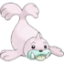

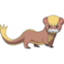

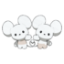

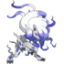

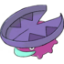

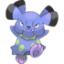

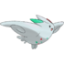

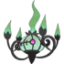

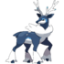

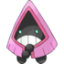

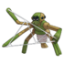

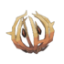

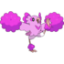

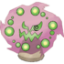

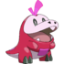

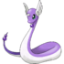

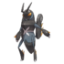

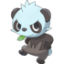

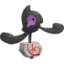

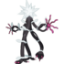

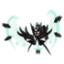

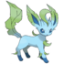

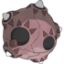

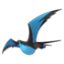

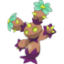

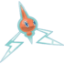

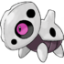

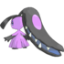

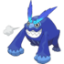

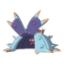

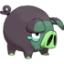

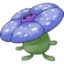

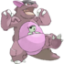

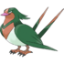

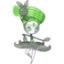

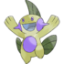

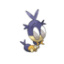

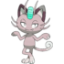

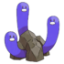

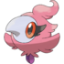

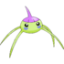

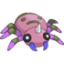

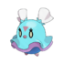

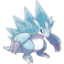

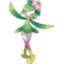

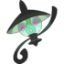

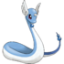

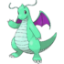

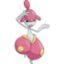

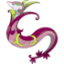

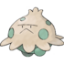

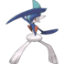

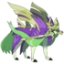

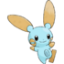

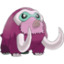

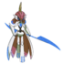

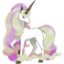

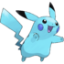

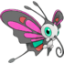

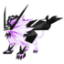

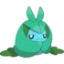

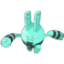

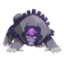

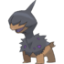

In [ ]:
bs = 64180
lr = 0.0002
T = 120
seed_size = 128
unroll_steps = 15
set_length = len(data_set) - 1
small_set = torch.utils.data.random_split(data_set, [set_length, len(data_set)-set_length])[0]
small_loader = torch.utils.data.DataLoader(data_set, batch_size = bs, shuffle = True)


show = True
for images, labels in small_loader:
  if show:
    print("labels: ", labels)
    for image in images:
      image += 1
      image /= 2
      transform = torchvision.transforms.ToPILImage()
      new_img = transform(image)
      new_img.show()
      show = False
  else:
    break



In [ ]:
generator = Generator(seed_size, bs)
discriminator = Discriminator(bs)

train_small(discriminator, generator, small_loader, seed_size, batch_size = bs, num_epochs = T, learning_rate = lr, unroll_steps = unroll_steps)

Starting Training


/usr/local/lib/python3.9/dist-packages/torch/autograd/__init__.py:200: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1151.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


KeyboardInterrupt: ignored

In [ ]:
discriminator_path, generator_path = get_model_path(batch_size = bs, learning_rate = lr, epoch = T - 1, drive = True)
plot_training_curve_small(discriminator_path, generator_path)

Test Generator

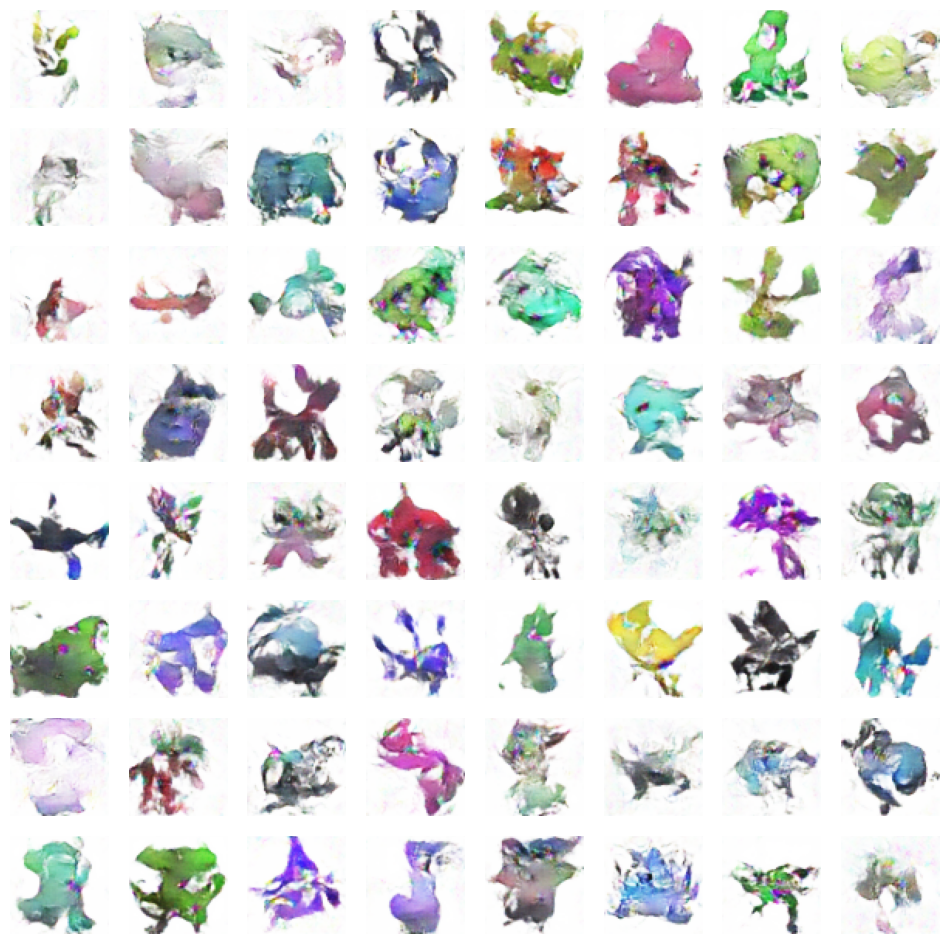

In [ ]:
# Choose loading device
#device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

bs = 64

# Initialize test models
# test_discriminator = Discriminator(bs)
test_generator = Generator(seed_size, bs)

discriminator_path, generator_path = get_model_path(bs, lr, 130, drive = True)
# discriminator_state = torch.load(discriminator_path, map_location = device)
generator_state = torch.load(generator_path, map_location = device)

# test_discriminator.load_state_dict(discriminator_state)
test_generator.load_state_dict(generator_state)

noise = torch.randn(bs, seed_size)
fake_imgs = test_generator(noise)

transform = torchvision.transforms.ToPILImage()
fig = plt.figure(figsize=(12, 12))
i = 0
for img in fake_imgs:
  img = img + 1
  img = img/2
  new_img = transform(img)
  fig.add_subplot(8, 8, i + 1)
  plt.imshow(new_img)
  plt.axis("off")
  #new_img.show()
  i += 1
plt.show()


Testing - FID (Frechet Inception Distance)

In [ ]:
!pip install -q pytorch-ignite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 7.0 MB/s eta 0:00:00


In [ ]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 10.5 MB/s eta 0:00:00


In [ ]:
pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install torch-fidelity

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#from ignite.metrics import FID
#from ignite.engine.engine import Engine
#from PIL import Image

from torchmetrics.image.fid import FrechetInceptionDistance

# Getting fake_imgs from our generator model --------------------

bs = 128
seed_size = 128

noise = torch.randn(bs, seed_size)
fake_imgs = test_generator(noise)

# Getting real_imgs from dataloader ------------------------------

ref_imgs = small_loader.dataset[0][0]
ref_imgs = torch.stack((ref_imgs, small_loader.dataset[1][0]), dim=0)

for img in range(2, bs):
  ref_imgs2 = small_loader.dataset[img][0].view(-1, 3, 64, 64)
  ref_imgs = torch.cat((ref_imgs, ref_imgs2), dim=0)

# FID ------------------------------------------------------------

fid = FrechetInceptionDistance(normalize=True)
fid.update(ref_imgs, real=True)
fid.update(fake_imgs, real=False)
fid_score = fid.compute()
print(fid_score)

# tensor(421.5051) epoch 85, apr 4th
# tensor(299.2932) epoch 69, random older one
# tensor(tensor(253.5289) epoch 119, apr 5th
# tensor(236.7915) epoch 190, apr 13th
# tensor(tensor(210.5040) epoch 130, apr 13th



tensor(235.7036)


In [ ]:

'''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize test models
test_discriminator = Discriminator(bs)
test_generator = Generator(seed_size, bs)

def eval_step(engine, batch):
    with torch.no_grad():
        noise = torch.randn(bs, 128)
        test_generator.eval()
        fake_batch = test_generator(noise)
        fake = batch_interpolate(fake_batch)
        real = batch_interpolate(batch[0])
        return fake, real

def batch_interpolate(batch):
  arr = []
  for img in batch:
    pil_img = transforms.ToPILImage()(img)
    resized_img = pil_img.resize((299,299), Image.BILINEAR)
    arr.append(transforms.ToTensor()(resized_img))
  return torch.stack(arr)

metric = FID()
default_evaluator = Engine(eval_step)
metric.attach(default_evaluator, 'fid')

default_evaluator.run(small_loader) #or normal dataset if no testing dataset
metrics = default_evaluator.state.metrics
fid_score = metrics['fid']

print('FID Score = {}'.format(fid_score))
'''

tensor([ 1,  0,  3,  0, -1], dtype=torch.int32)
tensor([ 1,  0,  3,  0, -1], dtype=torch.int8)
